In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import xgboost as xgb
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.utils.class_weight import compute_class_weight #样本不平衡 加权
from scipy.stats import randint, uniform

data = pd.read_csv(r'E:\Study\统计建模\python\data\data with AE(latent dim=6).csv')
X = data.drop(columns=['Diagnosis']).values
y = data['Diagnosis'].values
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#样本不平衡 加权
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))  # 转换为字典格式[5](@ref)
class_weights_dict
#sum/2/sum_0   sum/2/sum_1

{0: 0.6515189805561299, 1: 2.1499583027975033}

In [3]:
param_grid = {
    'learning_rate': uniform(0.1, 1),        # 学习率（推荐0.01-0.3）
    'n_estimators': randint(100, 200),          
    'max_depth': randint(1,10),
    # 正则化参数
    'gamma': uniform(0, 0.3),                  # 分裂增益阈值（推荐0-1）
    'reg_alpha': uniform(0, 1),                 # L1正则化系数（推荐0-10）
    'reg_lambda': uniform(0, 1),                # L2正则化系数（推荐0-10）
}

# 初始化带类别权重的基准模型
base_model = XGBClassifier(
    random_state=42,
    scale_pos_weight=4)

random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=50,
        scoring='accuracy',
        cv=5,
        n_jobs=-1,
        random_state=42
)

# 执行搜索
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe94abc3f80>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe94ab27380>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe9afe66480>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fe9afe67620>},
                   random_state=42, scoring='accuracy')

<span style="font-size: 20px;">最优超参数

In [4]:
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'gamma': np.float64(0.12826230550756487), 'learning_rate': np.float64(0.1254191267440952), 'max_depth': 3, 'n_estimators': 162, 'reg_alpha': np.float64(0.8957635956735194), 'reg_lambda': np.float64(0.47537022318211175)}


In [2]:
model=XGBClassifier(
    gamma=0.1282,
    learning_rate=0.1254,
    max_depth=3,
    n_estimators=162,
    reg_alpha=0.8957,
    reg_lambda=0.4753,
    random_state=42,scale_pos_weight=4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred,digits=4))

Confusion Matrix:
[[30601  2014]
 [ 5478  4446]]
Accuracy: 0.8239
              precision    recall  f1-score   support

           0     0.8482    0.9382    0.8909     32615
           1     0.6882    0.4480    0.5427      9924

    accuracy                         0.8239     42539
   macro avg     0.7682    0.6931    0.7168     42539
weighted avg     0.8109    0.8239    0.8097     42539



In [10]:
#训练集精度
accuracy_score( y_train, model.predict(X_train) )

0.8275541868447036

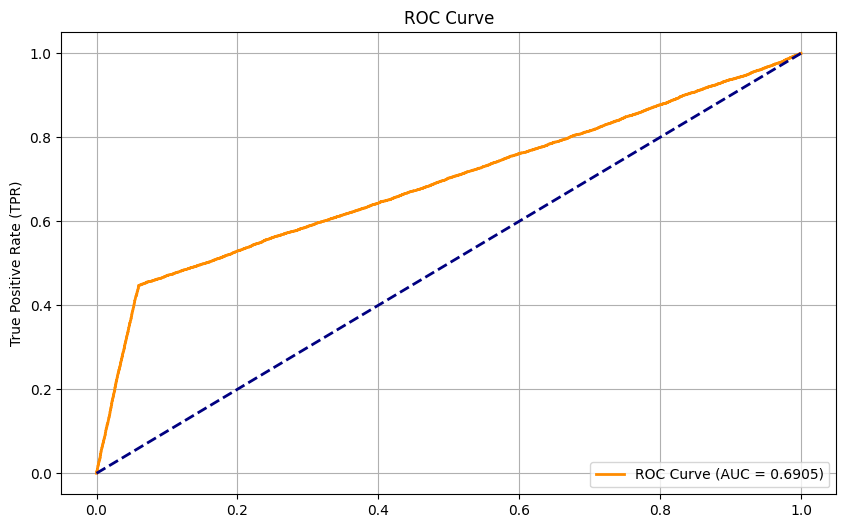

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score
y_score=model.predict_proba(X_test)[:,1]
# 计算ROC曲线和AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score,pos_label=1)
roc_auc = roc_auc_score(y_test, y_score)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [12]:
#保存预测值，为后续画图
# 将y_score转为DataFrame并自定义列名
combined_df = pd.DataFrame({
    'XGBoost': y_score
})
combined_df.to_csv('XGBoost.csv', index=False)